#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install shap -q
!pip install statsmodels -q
!pip install phik -q

In [2]:
import math
import re
import csv
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, make_scorer
import shap
from statsmodels.graphics.tsaplots import plot_acf
import phik

In [3]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [4]:
TEST_SIZE = 0.1

## Подготовка

In [5]:
with open('/datasets/taxi.csv') as file:
    data =  pd.read_csv(file, parse_dates=['datetime'], index_col=['datetime'])

In [6]:
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.shape

(4416, 1)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были загружены данные. Изначально временные интервалы были равны 10 минутам, после ресемплирования, размер фрейма уменьшился в 6 раз, итоговый фрейм содержит 4 416 строк.</p>

<hr>

## Анализ

In [8]:
def cor_heatmap(df: pd.DataFrame, parameters: list[str], 
                kind: str = 'Spearman', n_round: int=2,
                figsize: tuple[int] = (10, 10)) -> None:
    '''Heatmap of the correlation matrix (df[parameters])'''
    
    if kind == 'Phik':
        types = df.dtypes.reset_index()
        types.columns = ['index', 'type']
        quantitive = list(types.loc[(types['type'] == 'int64') | (types['type'] == 'float64'), 'index'])
        data_corr = df[parameters].phik_matrix(quantitive)
    elif kind == 'Pearson':
        data_corr = df[parameters].corr()
    elif kind == 'Spearman':
        data_corr = df[parameters].corr(method='spearman')
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(data_corr, dtype=bool))
    sns.heatmap(data_corr, 
                annot=True, 
                cmap='coolwarm',
                mask=mask,
                fmt=f".{n_round}f", 
                vmin=-1, 
                vmax=1, 
                center=0) 
    plt.title(f'Матрица корреляций, использующая метод {kind}', 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    plt.show()

<hr>

Проанализируем данные, для этого рассчитаем значения скользящего среднего, скользящего стандартного отклонения, разностей временного ряда, тренда и сезонности, а потом отобразим их на графике.
<a id='link_1'></a>

<hr>

In [9]:
data['mean'] = data['num_orders'].rolling(168).mean()
data['std'] = data['num_orders'].rolling(168).std()
data['diff'] = data['num_orders'] - data['num_orders'].shift()
data['trend'] = seasonal_decompose(data['num_orders']).trend
data['seasonal'] = seasonal_decompose(data['num_orders']).seasonal

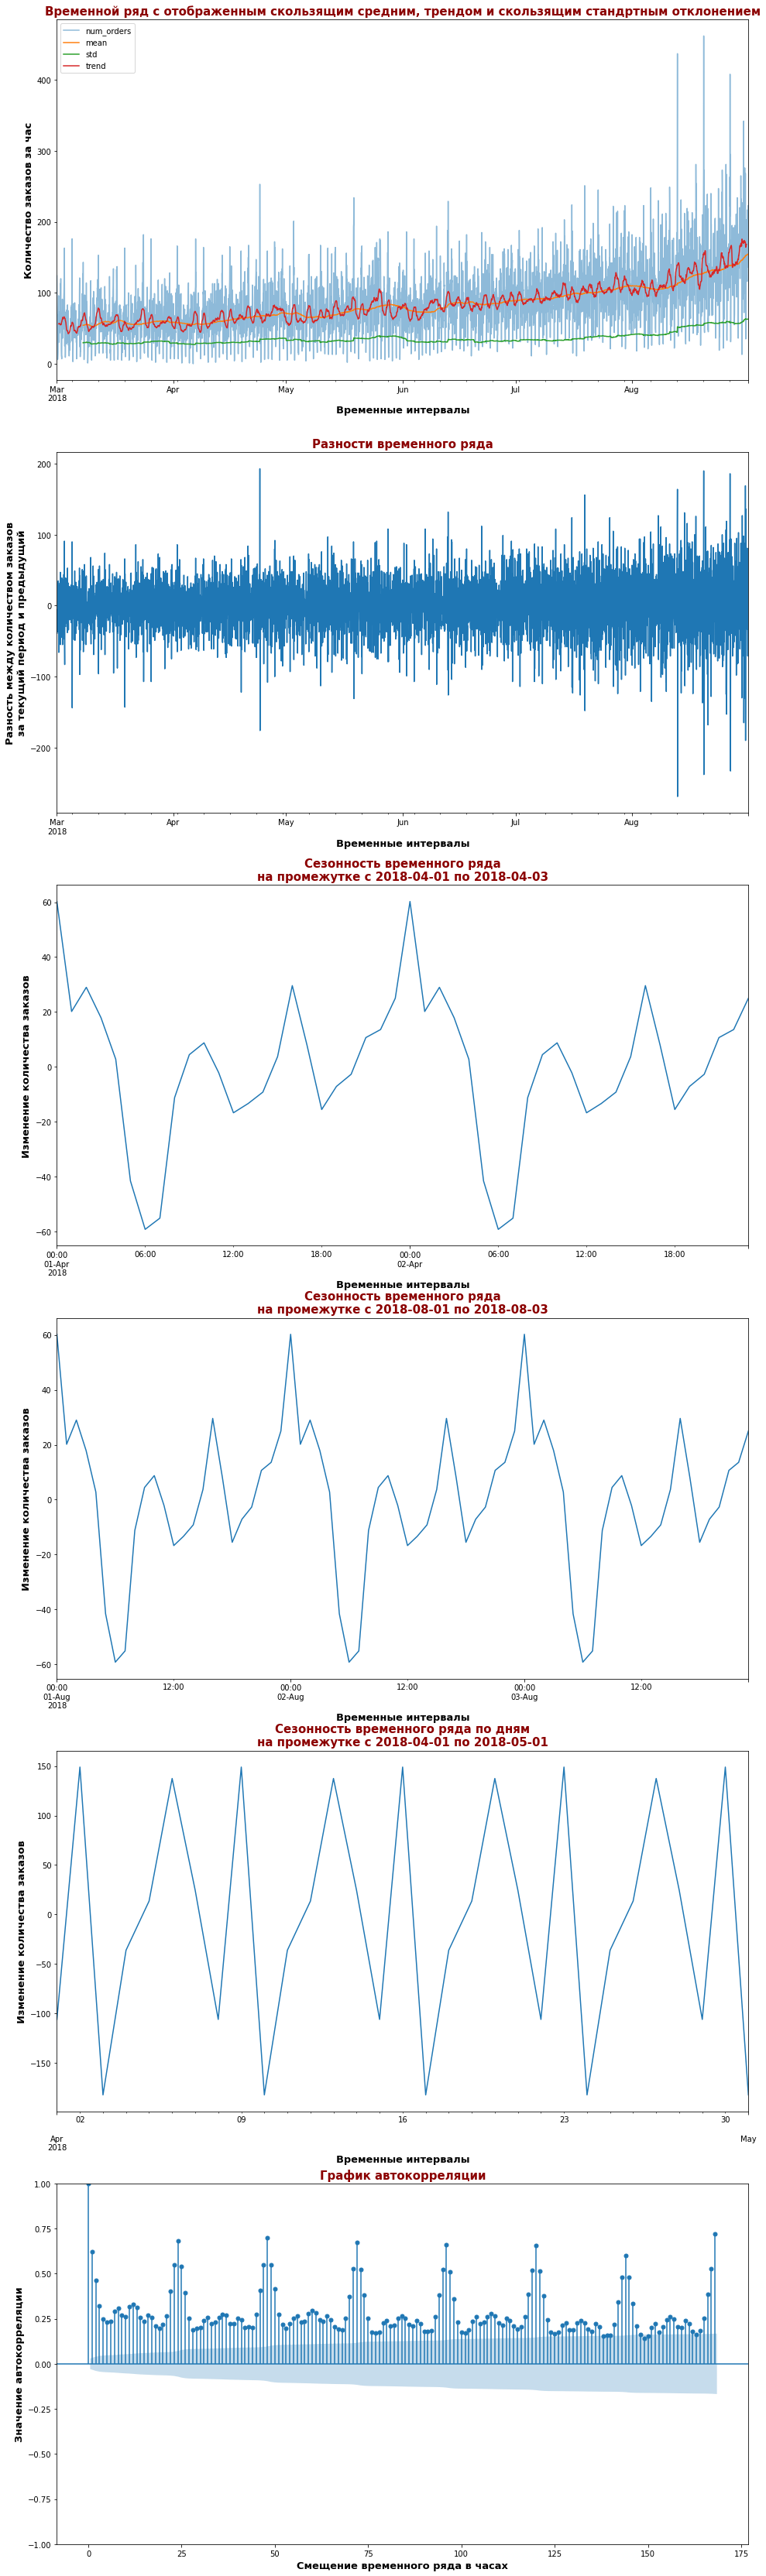

In [10]:
fig, axes = plt.subplots(6, 1, figsize=(16, 60))
data['num_orders'].plot(ax=axes[0], alpha=0.5)
data[['mean', 'std', 'trend']].plot(ax=axes[0])
axes[0].set_title('Временной ряд с отображенным скользящим средним, трендом и скользящим стандртным отклонением', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')
axes[0].set_ylabel('Количество заказов за час', weight='bold', size=13)
axes[0].legend()
data['diff'].plot(ax=axes[1])
axes[1].set_title('Разности временного ряда', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')
axes[1].set_ylabel('Разность между количеством заказов\nза текущий период и предыдущий', weight='bold', size=13)
data['seasonal']['2018-04-01':'2018-04-02'].plot(ax=axes[2])
axes[2].set_title('Сезонность временного ряда\nна промежутке с 2018-04-01 по 2018-04-03', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')
data['seasonal']['2018-08-01':'2018-08-03'].plot(ax=axes[3])
axes[3].set_title('Сезонность временного ряда\nна промежутке с 2018-08-01 по 2018-08-03', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')

data_by_day = data.resample('1D').sum()
data_by_day['seasonal'] = seasonal_decompose(data_by_day['num_orders']).seasonal
data_by_day['seasonal']['2018-04-01':'2018-05-01'].plot(ax=axes[4])
axes[4].set_title('Сезонность временного ряда по дням\nна промежутке с 2018-04-01 по 2018-05-01', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')

plot_acf(data['num_orders'], lags=168, ax=axes[5])
axes[5].set_title('График автокорреляции', 
                  weight='bold', 
                  size=15, 
                  color='DarkRed')
axes[5].set_xlabel('Смещение временного ряда в часах', weight='bold', size=13)
axes[5].set_ylabel('Значение автокорреляции', weight='bold', size=13)

[ax.set_ylabel('Изменение количества заказов', weight='bold', size=13) for ax in axes[2:5]]
[ax.set_xlabel('Временные интервалы', weight='bold', size=13) for ax in axes[:5]]
plt.show()

<hr>

<i>Описание графиков "Временной ряд с отображенным скользящим средним, трендом и скользящим стандртным отклонением" и "Разности временного ряда":</i>

 - По линии тренда и скользящему среднему можно сказать об общем увеличении количества заказов за промежуток в пол года (с марта по сентябрь);
 - Скользящее стандартное отклонение достаточно большое. Оно равномерное на временном промежутке с марта по июль, с июля по сентябрь - увеличивается;
 
<i>Описание графиков "Сезонность временного ряда на промежутке с 2018-04-01 по 2018-04-03" и "Сезонность временного ряда на промежутке с 2018-08-01 по 2018-08-03":</i>
 
 - Циклы временного ряда повторяется с частотой 1 сутки;
 - Амплитуда сезонных колебаний достаточно высокая и примерно равна 120;
 - Наибольшее количество заказов приходится на время 00:00, а наименьшее на 6:00;
 - Паттерны не меняются со временем;
 
<i>Описание графика "Сезонность временного ряда по дням на промежутке с 2018-04-01 по 2018-05-01":</i>

 - Циклы временного ряда повторяется с частотой 1 неделя;
 - Амплитуда сезонных колебаний примерно равна 300;
 - Наибольшее количество заказов приходится на 2 и 6 день, а наименьшее на 1 и 3 день;
 
<i>Описание графика "График автокорреляции":</i>

 - Сильнее всего временной ряд коррелирует со смещенной версией себя при смещениях 1 час, 1, 2, 3 и т.д. дня, 1, 2, 3 и т.д. недели;
 
<br><br>
Добавим признаки, которые будут использоваться для обучения моделей и предсказаний. И построим корреляционную матрицу для них.

<hr>

In [11]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
for i in [1, 3, 6, 12, 24]:
    data[f'lag_{i}'] = data['num_orders'].shift(i)

data[f'rolling_mean'] = data['num_orders'].shift().rolling(6).mean()

['num_orders', 'mean', 'std', 'diff', 'trend', 'seasonal', 'dayofweek', 'hour', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'rolling_mean']


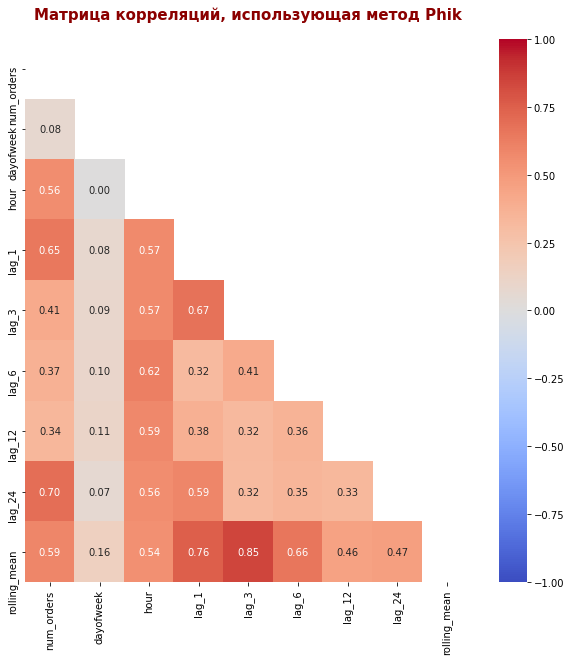

In [12]:
cor_heatmap(data, data.columns.drop(['mean', 'std', 'diff', 'trend', 'seasonal']), kind='Phik')

<hr>

Мультиколлинеарность между признаками не наблюдается.

<hr>

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе был проведен анализ данных, а также добавлены признаки для обучения.<br><br><i>Описание графиков "Временной ряд с отображенным скользящим средним, трендом и скользящим стандртным отклонением" и "Разности временного ряда":</i></p>

 - По линии тренда и скользящему среднему можно сказать об общем увеличении количества заказов за промежуток в пол года (с марта по сентябрь);
 - Скользящее стандартное отклонение достаточно большое. Оно равномерное на временном промежутке с марта по июль, с июля по сентябрь - увеличивается;
 
<i>Описание графиков "Сезонность временного ряда на промежутке с 2018-04-01 по 2018-04-03" и "Сезонность временного ряда на промежутке с 2018-08-01 по 2018-08-03":</i>
 
 - Циклы временного ряда повторяется с частотой 1 сутки;
 - Амплитуда сезонных колебаний достаточно высокая и примерно равна 120;
 - Наибольшее количество заказов приходится на время 00:00, а наименьшее на 6:00;
 - Паттерны не меняются со временем;
 
<i>Описание графика "Сезонность временного ряда по дням на промежутке с 2018-04-01 по 2018-05-01":</i>

 - Циклы временного ряда повторяется с частотой 1 неделя;
 - Амплитуда сезонных колебаний примерно равна 300;
 - Наибольшее количество заказов приходится на 2 и 6 день, а наименьшее на 1 и 3 день;
 
<i>Описание графика "График автокорреляции":</i>

 - Сильнее всего временной ряд коррелирует со смещенной версией себя при смещениях 1 час, 1, 2, 3 и т.д. дня, 1, 2, 3 и т.д. недели;
 
Признаки, добавленные для предсказания моедлью целевого значения:

 - <b>dayofweek</b> — номер дня недели, где 0 это понедельник, а 6 - воскресенье;
 - <b>hour</b> — час дня;
 - <b>lag_n</b> — отстающие значение на n;
 - <b>rolling_mean</b> — скользящее среднее по окну 6, не учитывающее текущее значение;

Мультиколлинеарность между признаками не наблюдается.

<hr>

## Обучение

In [14]:
def residuals_analysis(y_test: pd.DataFrame, predictions: np.ndarray, 
                       figsize: tuple[int]=(16, 8), bins: int=10,
                       title_size: int=18, xy_labels_size: int=12) -> pd.DataFrame:
    '''Construction of residuals histogram and scatter plot '''
    
        
    residuals = y_test - predictions
    mean_residuals = residuals.mean()
    median_residuals = residuals.median()
    
    fig = plt.figure(figsize=figsize)
    
    
    fig.add_subplot(1, 2, 1)
    plt.hist(residuals, bins=bins)
    plt.axvline(mean_residuals, color='lightblue', 
                linestyle='dashed', 
                linewidth=2, 
                label=f'Среднее: {mean_residuals:.2f}')
    plt.axvline(median_residuals, color='lightgreen', 
                linestyle='dashed', 
                linewidth=2, 
                label=f'Медианное: {median_residuals:.2f}')
    plt.title('Гистограмма распределения остатков', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.legend()
    plt.grid()
    
    
    fig.add_subplot(1, 2, 2)
    plt.scatter(predictions, 
                residuals, 
                alpha=0.3)
    plt.title('Анализ дисперсии', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Предсказания модели', 
               size=xy_labels_size, 
               weight='bold')
    plt.ylabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.grid()
    
    
    plt.show()
    return residuals

<hr>

<p style='text-align: justify;'>Выделим тренеровочную и тестовую выборки в соотношении 9/1. Создадим трансформер для нормализации количественных значений. Соберем общий пайплайн и определим параметры моделей. Обучим 3 модели: <i>KNeighborsRegressor</i>, <i>LGBMRegressor</i> и <i>CatBoostRegressor</i>, в качестве метрики будем использовать <i>RMSE</i>. Обучать модели будем при помощи инструмента <i>RandomizedSearchCV</i>.</p>

<hr>

In [15]:
data = data.dropna()

In [16]:
cat_columns = ['dayofweek', 'hour']

X_train, X_test, y_train, y_test = train_test_split(data[data.columns.drop(['mean', 'std', 'diff', 
                                                                            'trend', 'seasonal', 'num_orders'])], 
                                                    data['num_orders'], 
                                                    shuffle=False, 
                                                    test_size=TEST_SIZE)

X_train[cat_columns] = X_train[cat_columns].astype('category')
X_test[cat_columns] = X_test[cat_columns].astype('category')

In [17]:
ohe_pipe = Pipeline([('ohe', 
                      OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])
data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, cat_columns), 
                                       ('num', StandardScaler(), X_train.columns)], 
                                      remainder='passthrough')

In [18]:
pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', None)])

In [19]:
knr_params = {'models':[KNeighborsRegressor()],
              'models__n_neighbors':range(3, 20),
              'models__algorithm':['ball_tree', 'kd_tree', 'brute']}

lgbm_params = {'preprocessor':[None],
               'models':[lgb.LGBMRegressor(learning_rate=0.05)], 
               'models__max_depth':range(2, 10), 
               'models__num_leaves':range(2, 10),
               'models__n_estimators':range(30, 300)}

ctb_params = {'preprocessor':[None], 
              'models':[CatBoostRegressor(verbose=0, cat_features=cat_columns)], 
              'models__max_depth':range(2, 10), 
              'models__n_estimators':range(30, 300)}

In [20]:
tscv = TimeSeriesSplit(n_splits=5)
for model in ['knr', 'lgbm', 'ctb']:
    globals()[f'{model}_rand_search'] = RandomizedSearchCV(pipe_final, 
                                                           globals()[f'{model}_params'], 
                                                           cv=tscv, 
                                                           scoring='neg_root_mean_squared_error', 
                                                           n_jobs=-1, 
                                                           n_iter=5, 
                                                           verbose=0)

<hr>

<div align='center'><b>Модель KNeighborsRegressor</b></div>

<hr>

In [21]:
%%time

_ = knr_rand_search.fit(X_train, y_train);

CPU times: user 2.1 s, sys: 458 ms, total: 2.55 s
Wall time: 2.55 s


In [22]:
knr_predictions = knr_rand_search.predict(X_test)
print(f'Лучшая метрика RMSE модели KNeighborsRegressor при валидации: {-knr_rand_search.best_score_:.1f}')

Лучшая метрика RMSE модели KNeighborsRegressor при валидации: 26.3


<hr>

<div align='center'><b>Модель LGBMRegressor</b></div>

<hr>

In [23]:
%%time

_ = lgbm_rand_search.fit(X_train, y_train);

CPU times: user 17.5 s, sys: 122 ms, total: 17.6 s
Wall time: 17.8 s


In [24]:
lgbm_predictions = lgbm_rand_search.predict(X_test)
print(f'Лучшая метрика RMSE модели LGBMRegressor при валидации: {-lgbm_rand_search.best_score_:.1f}')

Лучшая метрика RMSE модели LGBMRegressor при валидации: 24.7


<hr>

<div align='center'><b>Модель CatBoostRegressor</b></div>

<hr>

In [25]:
%%time

_ = ctb_rand_search.fit(X_train, y_train);

CPU times: user 25.3 s, sys: 3.59 s, total: 28.9 s
Wall time: 43.8 s


In [26]:
ctb_predictions = ctb_rand_search.predict(X_test)
print(f'Лучшая метрика RMSE модели CatBoostRegressor при валидации: {-ctb_rand_search.best_score_:.1f}')

Лучшая метрика RMSE модели CatBoostRegressor при валидации: 24.7


<hr>

Почтроим графики с распределением и дисперсией остатков моделей.

<hr>


                                           Анализ остатков модели KNeighborsRegressor                                          


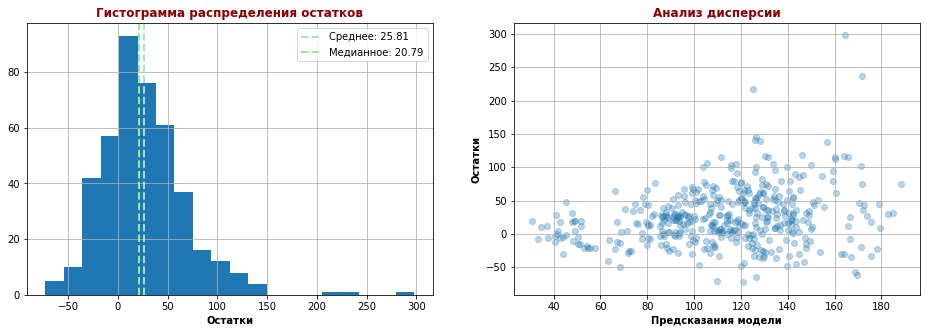


                                              Анализ остатков модели LGBMRegressor                                             


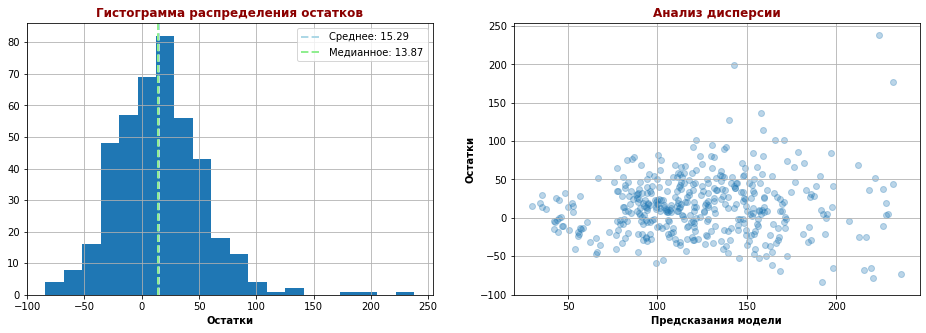


                                            Анализ остатков модели CatBoostRegressor                                           


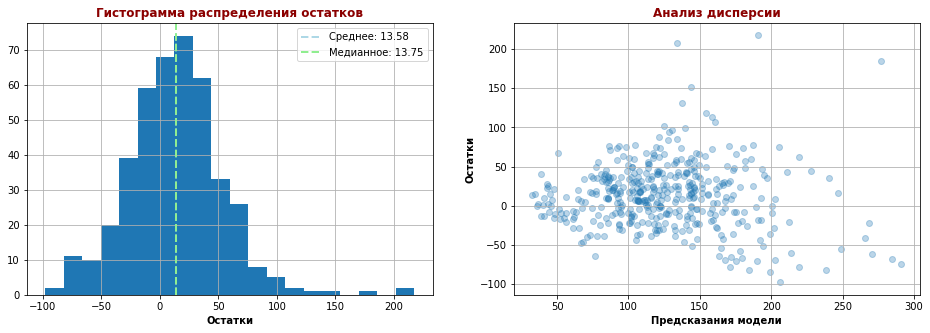

In [27]:
names = {'knr':'KNeighborsRegressor', 'lgbm':'LGBMRegressor', 'ctb':'CatBoostRegressor'}
for model in ['knr', 'lgbm', 'ctb']:
    print('\n', f'\033[1mАнализ остатков модели {names[model]}'.center(130))
    residuals_dtr = residuals_analysis(y_test=y_test, 
                                       predictions=globals()[f'{model}_predictions'], 
                                       figsize=(16, 5), 
                                       title_size=12, 
                                       xy_labels_size=10, 
                                       bins=20)

<hr>

Анализ остатков модели <i>KNeighborsRegressor</i> показал:
 
 - Распределение остатков немного отклонено вправо, это значит, что модель чаще будет занижать предсказанные значения.
 - Дисперсия остатков неравномерная, при значениях более 75 модель часто занижает значение, также присутствуют несколько выбросов (до 300) при предсказанных значениях больше 120, значит модель несколько раз сильно занизила предсказанные значения.
 
Анализ остатков модели <i>LGBMRegressor</i> показал:

 - Распределение также смещено вправо, что говорит об общем занижении предсказанных значений.
 - Дисперсия остатков неравномерная, при значениях более 75 модель часто занижает значение, также присутствуют несколько выбросов (до 250) при предсказанных значениях больше 120, значит модель несколько раз сильно занизила предсказания.

Анализ остатков модели <i>CatBoostRegressor</i> показал:

 - Предсказания в общем завышены.
 - Дисперсия похожа на дисперсию модели <i>LGBMRegressor</i>, но с большим количество завышенных предсказаний.

<hr>

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Были обучены 3 модели: <i>KNeighborsRegressor</i>, <i>LGBMRegressor</i> и <i>CatBoostRegressor</i>.</p>

Характеристики модели <b>KNeighborsRegressor</b>:

 - Время обучения модели: ~1-3 секунды;
 - Качество при валидации: 26.3;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
Характеристики модели <b>LGBMRegressor</b>:

 - Время обучения модели: ~10-30 секунд;
 - Качество при валидации: 24.7;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
Характеристики модели <b>CatBoostRegressor</b>:

 - Время обучения модели: ~20-40 секунд;
 - Качество при валидации: 24.9;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
Модель <i>LGBMRegressor</i> получилась наилучшей по критериям: <i>время обучения</i>, <i>качество</i> и <i>характеристика остатков</i>.

<hr>

## Тестирование

In [28]:
lgbm_rmse = mean_squared_error(y_test, lgbm_predictions, squared=False)
print(f'RMSE модели LGBMRegressor на тестовых данных: {lgbm_rmse:.1f}')

RMSE модели LGBMRegressor на тестовых данных: 41.9


<hr>

Построим графики важности признаков модели с помощью метода <b>SHAP</b>.

<hr>

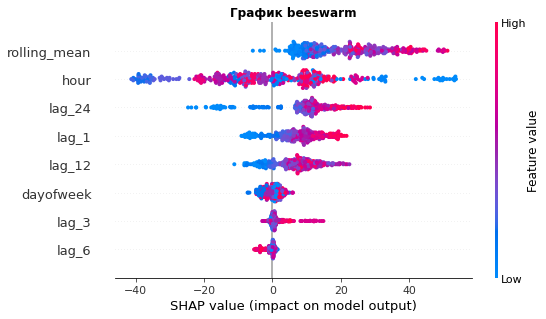

In [29]:
best_model = lgbm_rand_search.best_estimator_.named_steps['models']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

plt.title('График beeswarm', weight='bold')
shap.plots.beeswarm(shap_values) 

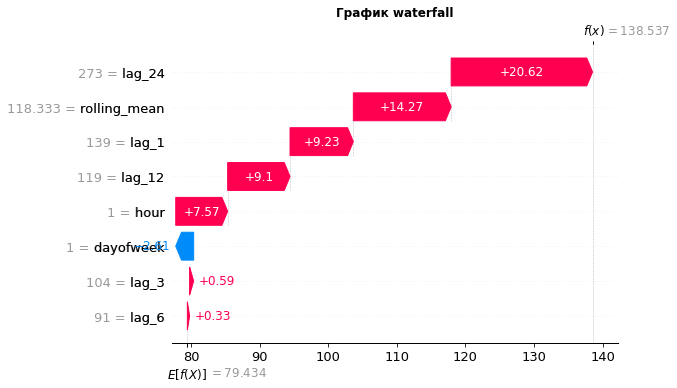

In [30]:
plt.title('График waterfall', weight='bold')
shap.plots.waterfall(shap_values[5]) 

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Была рассчитана метрика <i>RMSE</i> на тестовых данных, получено значение - 41.9.<br>Были построены графики важности признаков модели с помощью метода <b>SHAP</b>.<br><br>График <b>beeswarm</b>:</p>

 - Больший вклад вносят признаки: сколльзящее среднее по окну, час и смещение на 24 часа;
 - Высокое значение сколльзящего среднего по окну влияет на увеличение количества заказов;
 - Ранние часы влияют как на уменьшение, так и на увеличение количества заказов;
 - Низкие значения смещения на 24 влияют на уменьшение количества заказов, высокие наоборот на увеличение;
 
График <b>waterfall</b>:

 - Отображено влияние признаков для одного из наблюдений в выборке;
 - Наибольшее влияние на увеличение прогнозируемого значения заказов внес признак <i>lag_24</i>, весомое влияние также внесли признаки <i>rollin_mean</i>, <i>lag_1</i> и <i>lag_12</i>, остальные признаки внесли незначительное влияние.

<hr>

## Общий вывод

<p style='text-align: justify;'>В данной работе был проведен анализ данных о заказах такси в аэропортах для компании «Чётенькое такси», чтобы привлекать больше водителей в период пиковой нагрузки.<br><br>Сначала были загружены данные. после загрузки временные интервалы были равны 10 минутам, после ресемплирования, размер фрейма уменьшился в 6 раз, итоговый фрейм содержит 4 416 строк.</p>

<p style='text-align: justify;'>Далее был проведен анализ данных, а также добавлены признаки для обучения.<br><br><i>Описание графиков</i> <a href='#link_1'>"Временной ряд с отображенным скользящим средним, трендом и скользящим стандртным отклонением" и "Разности временного ряда"</a>:</p>

 - По линии тренда и скользящему среднему можно сказать об общем увеличении количества заказов за промежуток в пол года (с марта по сентябрь);
 - Скользящее стандартное отклонение достаточно большое. Оно равномерное на временном промежутке с марта по июль, с июля по сентябрь - увеличивается;
 
<i>Описание графиков <a href='#link_1'>"Сезонность временного ряда на промежутке с 2018-04-01 по 2018-04-03" и "Сезонность временного ряда на промежутке с 2018-08-01 по 2018-08-03":</a></i>
 
 - Циклы временного ряда повторяется с частотой 1 сутки;
 - Амплитуда сезонных колебаний достаточно высокая и примерно равна 120;
 - Наибольшее количество заказов приходится на время 00:00, а наименьшее на 6:00;
 - Паттерны не меняются со временем;
 
<i>Описание графика <a href='#link_1'>"Сезонность временного ряда по дням на промежутке с 2018-04-01 по 2018-05-01"</a>:</i>

 - Циклы временного ряда повторяется с частотой 1 неделя;
 - Амплитуда сезонных колебаний примерно равна 300;
 - Наибольшее количество заказов приходится на 2 и 6 день, а наименьшее на 1 и 3 день;
 
<i>Описание графика <a href='#link_1'>"График автокорреляции"</a>:</i>

 - Сильнее всего временной ряд коррелирует со смещенной версией себя при смещениях 1 час, 1, 2, 3 и т.д. дня, 1, 2, 3 и т.д. недели;
 
Признаки, добавленные для предсказания моедлью целевого значения:

 - <b>dayofweek</b> — номер дня недели, где 0 это понедельник, а 6 - воскресенье;
 - <b>hour</b> — час дня;
 - <b>lag_n</b> — отстающие значение на n;
 - <b>rolling_mean</b> — скользящее среднее по окну 6, не учитывающее текущее значение;

Мультиколлинеарность между признаками не наблюдается.

<p style='text-align: justify;'>После этого были обучены 3 модели: <i>KNeighborsRegressor</i>, <i>LGBMRegressor</i> и <i>CatBoostRegressor</i>.</p>

Характеристики модели <b>KNeighborsRegressor</b>:

 - Время обучения модели: ~1-3 секунды;
 - Качество при валидации: 26.3;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
Характеристики модели <b>LGBMRegressor</b>:

 - Время обучения модели: ~10-30 секунд;
 - Качество при валидации: 24.7;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
Характеристики модели <b>CatBoostRegressor</b>:

 - Время обучения модели: ~20-40 секунд;
 - Качество при валидации: 24.9;
 - Характеристики распределение остатков: немного занижает предсказанные значения; 
 - Характеристики дисперсии остатков: неравномерное, иногда сильно занижает предсказания (до 250);
 
<p style='text-align: justify;'>Модель <i>LGBMRegressor</i> получилась наилучшей по критериям: <i>время обучения</i>, <i>качество</i> и <i>характеристика остатков</i>. Для нее была рассчитана метрика <i>RMSE</i> на тестовых данных, получено значение - 41.9, что соответствует требованию <i>"Значение метрики RMSE на тестовой выборке должно быть не больше 48."</i>. Также были построены графики важности признаков модели с помощью метода <b>SHAP</b>.<br><br>График <b>beeswarm</b>:</p>

 - Больший вклад вносят признаки: сколльзящее среднее по окну, час и смещение на 24 часа;
 - Высокое значение сколльзящего среднего по окну влияет на увеличение количества заказов;
 - Ранние часы влияют как на уменьшение, так и на увеличение количества заказов;
 - Низкие значения смещения на 24 влияют на уменьшение количества заказов, высокие наоборот на увеличение;
 
График <b>waterfall</b>:

 - Отображено влияние признаков для одного из наблюдений в выборке;
 - Наибольшее влияние на увеличение прогнозируемого значения заказов внес признак <i>lag_24</i>, весомое влияние также внесли признаки <i>rollin_mean</i>, <i>lag_1</i> и <i>lag_12</i>, остальные признаки внесли незначительное влияние.